# Init

In [1]:
# from skfem import *
import numpy as np
from utils import *
from skfem.helpers import d, dd, ddd, dot, ddot, grad, dddot, prod
from scipy.sparse.linalg import LinearOperator, minres
# from skfem.models.poisson import *
from skfem.assembly import BilinearForm, LinearForm
import datetime
import pandas as pd
from skfem.visuals.matplotlib import draw, plot
import sys
import time

tol = 1e-8
intorder = 5
solver_type = 'mgcg'
refine_time = 5
epsilon_range = 6
element_type = 'P1'
sigma = 5
penalty = False
# epsilon = 1e-5
example = 'ex4'
save_path = 'log/' + example + '_' + element_type + '_' + ('pen' if penalty else 'nopen') + '_' +'{}'.format(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

In [2]:
def dirichlet(w):
    """return a harmonic function"""
    global out
    x, y = w
    out = np.zeros_like(x)
    if x.ndim == 2:
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                if x[i, j] != 0:
                    out[i, j] = (x[i, j]**2 + y[i, j]**2)**(5 / 6) * sin(5 * atan(y[i, j] / x[i, j]) / 3)
                elif y[i, j] > 0:
                    out[i, j] = (x[i, j]**2 + y[i, j]**2)**(5 / 6) * sin(90 * 5 / 3)
                else:
                    out[i, j] = (x[i, j]**2 + y[i, j]**2)**(5 / 6) * sin(270 * 5 / 3)
    elif x.ndim == 1:
        for i in range(x.shape[0]):
            if x[i] != 0:
                out[i] = (x[i]**2 + y[i]**2)**(5 / 6) * sin(5 * atan(y[i] / x[i]) / 3)
            elif y[i] > 0:
                out[i] = (x[i]**2 + y[i]**2)**(5 / 6) * sin(90 * 5 / 3)
            else:
                out[i] = (x[i]**2 + y[i]**2)**(5 / 6) * sin(270 * 5 / 3)
    else:
        raise Exception("dim not supported")
    return out

In [49]:
def solve_problem1(m, element_type='P1', solver_type='pcg', intorder=6, tol=1e-8, epsilon=1e-6):
    '''
    switching to mgcg solver for problem 1
    '''
    if element_type == 'P1':
        element = {'w': ElementTriP1(), 'u': ElementTriMorley()}
    elif element_type == 'P2':
        element = {'w': ElementTriP2(), 'u': ElementTriMorley()}
    else:
        raise Exception("Element not supported")

    basis = {
        variable: InteriorBasis(m, e, intorder=intorder)
        for variable, e in element.items()
    }
    
    K1 = asm(laplace, basis['w'])
    f1 = asm(f_load, basis['w'])
    wh = solve(*condense(K1, f1, D=basis['w'].find_dofs()), solver=solver_iter_mgcg(tol=tol))
    
    global K2, f2, uh0, boundary_dofs, boundary_basis
    K2 = epsilon**2 * asm(a_load, basis['u']) + asm(b_load, basis['u'])
    f2 = asm(wv_load, basis['w'], basis['u']) * wh
    
#     boundary_basis = FacetBasis(m, element['w'])
    boundary_basis = FacetBasis(m, ElementTriMorley())
#     boundary_dofs = boundary_basis.find_dofs()['u'].all()
    boundary_dofs = boundary_basis.find_dofs()['all'].all()
    uh0 = np.zeros(basis['u'].N)
    uh0[boundary_dofs] = pproject(dirichlet, basis_to=boundary_basis, I=boundary_dofs, solver=minres)

#     uh0 = solve(*condense(K2, f2, D=easy_boundary(m, basis['u'])), solver=solver_iter_mgcg(tol=tol))
#     uh0 = solve(*condense(K2, f2, D=basis['u'].find_dofs()), solver=solver_iter_mgcg(tol=tol))
#     uh0 = solve(*condense(K2, f2, uh0, D=boundary_dofs), solver=solver_iter_krylov(minres, tol=tol))
    uh0 = solve(*condense(K2, f2, uh0, D=boundary_dofs), solver=solver_iter_mgcg(tol=tol))

    return uh0, basis

# Solving

In [56]:
boundary_dofs

array([  0,   1,   2,   3,   4,   5,   7,   8,   9,  10,  11,  13,  14,
        16,  17,  18,  25,  26,  27,  29,  30,  32,  33,  34,  35,  36,
        39,  40,  49,  50,  53,  54,  81,  82,  83,  85,  86,  88,  89,
        90,  91,  92,  95,  96, 105, 106, 109, 110, 113, 114, 117, 118,
       121, 122, 131, 132, 135, 136, 145, 146, 149, 150, 153, 154],
      dtype=int64)

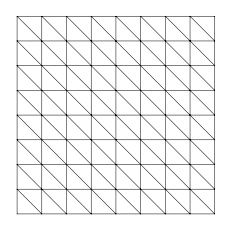

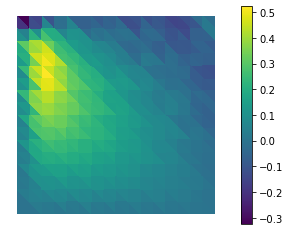

In [55]:
# m = MeshTri().init_lshaped()
m = MeshTri()
m.refine(3)
draw(m)

epsilon = 0
ep = epsilon

uh0, basis = solve_problem1(m, element_type, solver_type, intorder, tol, epsilon)

x = basis['u'].doflocs[0]
y = basis['u'].doflocs[1]
u = exact_u(x, y)
plot(basis['u'], u-uh0, colorbar=True)

In [35]:
exact_u(x, y)

array([-0.        ,  0.        , -0.71487643,  1.72108416,  0.        ,
       -0.22517197,  0.54210754,  0.84077245,  1.159291  ,  0.        ,
       -0.07092472,  0.        ,  0.34534261,  0.41762199, -0.44258812,
        0.58959925,  0.8443497 ,  1.27411462,  1.45003215,  0.17075318,
        0.26482673,  0.36515378,  0.6985417 ,  0.83921196,  1.06554275])

In [36]:
dirichlet([x, y])

array([-0.        ,  0.        , -0.71487643,  1.72108416,  0.        ,
       -0.22517197,  0.54210754,  0.84077245,  1.159291  ,  0.        ,
       -0.07092472,  0.        ,  0.34534261,  0.41762199, -0.44258812,
        0.58959925,  0.8443497 ,  1.27411462,  1.45003215,  0.17075318,
        0.26482673,  0.36515378,  0.6985417 ,  0.83921196,  1.06554275])

In [ ]:
exact_u(np.array([-0.00000]), np.array([0.8]))

In [ ]:
dirichlet([np.array([[-0.00000]]), np.array([[0.8]])])

In [46]:
boundary_basis.mesh

Triangular mesh with 9 vertices and 8 elements.

In [42]:
exact_u(boundary_basis.doflocs[0], boundary_basis.doflocs[1])

array([-0.        ,  0.        , -0.71487643,  1.72108416,  0.        ,
       -0.22517197,  0.54210754,  0.84077245,  1.159291  ,  0.        ,
       -0.07092472,  0.        ,  0.34534261,  0.41762199, -0.44258812,
        0.58959925,  0.8443497 ,  1.27411462,  1.45003215,  0.17075318,
        0.26482673,  0.36515378,  0.6985417 ,  0.83921196,  1.06554275])

In [37]:
pproject(dirichlet, basis_to=boundary_basis, I=boundary_dofs, solver=minres)

array([-3.43008346e-02, -1.00956557e-03, -1.01357693e-01,  1.75830776e+00,
       -2.84292163e-03, -4.41236186e-01,  8.42372919e-01,  1.38280152e+00,
        1.14911502e+00, -6.24112046e-01, -3.26250313e-18,  0.00000000e+00,
        0.00000000e+00,  1.93454940e-16,  6.84454214e-01, -7.89020539e-01])

In [ ]:
plot(basis['u'], u, colorbar=True)

In [ ]:
plot(basis['u'], uh0, colorbar=True)

In [ ]:
(uh0 - u)[:30]

In [ ]:
u

In [ ]:
time_start = time.time()

print('=======Arguments=======')
print('penalty:\t{}'.format(penalty))
print('element_type:\t{}'.format(element_type))
print('solver_type:\t{}'.format(solver_type))
print('tol:\t{}'.format(tol))
print('intorder:\t{}'.format(intorder))
print('refine_time:\t{}'.format(refine_time))
print('sigma:\t{}'.format(sigma))
print('=======Results=======')

df_list = []
for j in range(epsilon_range):
    epsilon = 1 * 10**(-j)
    ep = epsilon
    L2_list = []
    Du_list = []
    D2u_list = []
    h_list = []
    epu_list = []
#     m = MeshTri().init_lshaped()
    m = MeshTri()
#     draw(m)

    for i in range(1, refine_time+1):
        
        m.refine()
        
        if penalty:
            uh0, basis, fbasis = solve_problem2(m, element_type, solver_type, intorder, tol, epsilon)
        else:
            uh0, basis = solve_problem1(m, element_type, solver_type, intorder, tol, epsilon)

        U = basis['u'].interpolate(uh0).value

        # compute errors

        L2u = np.sqrt(L2uError.assemble(basis['u'], w=U))
        Du = get_DuError(basis['u'], uh0)
        H1u = Du + L2u
        if penalty:
            D2u = np.sqrt(get_D2uError(basis['u'], uh0)**2 + L2pnvError.assemble(fbasis, w=fbasis.interpolate(uh0)))
        else:
            D2u = get_D2uError(basis['u'], uh0)
        epu = np.sqrt(epsilon**2 * D2u**2 + Du**2)
        h_list.append(m.param())
        Du_list.append(Du)
        L2_list.append(L2u)
        D2u_list.append(D2u)
        epu_list.append(epu)
        
    hs = np.array(h_list)
    L2s = np.array(L2_list)
    Dus = np.array(Du_list)
    D2us = np.array(D2u_list)
    epus = np.array(epu_list)
    H1s = L2s + Dus
    H2s = H1s + D2us
    
    # store data
    data = np.array([L2s, H1s, H2s, epus])
    df = pd.DataFrame(data.T, columns=['L2', 'H1', 'H2', 'Energy'])
    df_list.append(df)
    
    print('epsilion:', epsilon)
    show_result(L2s, H1s, H2s, epus)

time_end = time.time()

result = df_list[0].append(df_list[1:])
result.to_csv(save_path+'.csv')
print('======= Errors saved in:', save_path+'.csv ==========')
print('Total Time Cost {:.2f} s'.format(time_end-time_start))